# Using XGBoost in Python Tutorial

## Motivation
- Give a brief motivation why you should learn XGBoost
- List a few of its advantages

## What you will learn in this tutorial
- Directly tell the topics and features of XGB covered in the tutorial

## Installation

XGBoost can be installed like any other library through `pip`. This method of installation will also include support for your machine's NVIDIA GPU. If you want to install CPU only version, you can go with `conda-forge`:

```python
$ pip install --user xgboost 
# CPU only
$ conda install -c conda-forge py-xgboost-cpu
# Use NVIDIA GPU
$ conda install -c conda-forge py-xgboost-gpu
```

> I hope I don't have to tell you that the library should be installed in a virtual environment.

I strongly recommend to run through the examples in the tutorial with GPU-enabled machine. If you don't have one, you can check out alternatives like [Google Colab](https://colab.research.google.com/) or [DataCamp Workspace](https://www.datacamp.com/workspace).

If you decide to go with Colab, it has the old version of XGBoost installed, so you should call `pip install --upgrade xgboost` to get the latest version.

## Loading and exploring the data

We will be working with the Diamonds dataset throughout the tutorial. It has a nice combination of numeric and categorical features and over 50k observations that we can comfortably showcase all the advantages of XGBoost. 

```python
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

diamonds = sns.load_dataset("diamonds")
diamonds.head()
```

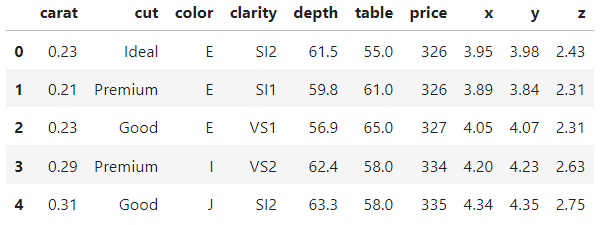

```python
>>> diamonds.shape
```

```
(53940, 10)
```

In a typical real-world project, you would want to spend a lot more time exploring the dataset and visualizing its features. But since this data comes built-in to Seaborn, it is relatively clean.

So, we will just look at the 5-number summary of the numeric and categorical features and get going. Spend a few moments to familiarize yourself.

```python
diamonds.describe()
```

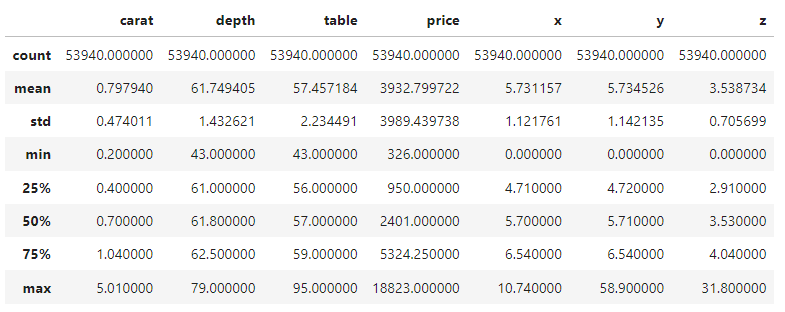

```python
diamonds.describe(exclude=np.number)
```

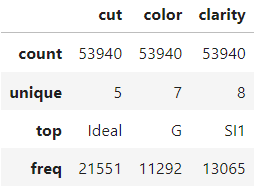

## Building an XGBoost DMatrix

After you are done exploration, the first step in any project is framing the machine learning problem and extract the feature and target arrays based on the dataset.

In this tutorial, we will first try to predict Diamond prices using their physical measurements, so our target will be the `price` column. 

So, we are isolating the features into `X` and the target into `y`:

```python
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
```

The dataset has three categorical columns. Normally, you would encode them with ordinal or one-hot encoding but XGBoost has the ability to internally deal with categoricals.

The way to enable this feature is to cast the categorical columns into Pandas `category` data type (by default, they are treated as text columns):

```python
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')
```

Now, when you see the `dtypes` attribute,  you'll see that we have three `category` features:

```
>>> X.dtypes
```

```
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object
```

Let's split the data into train and test sets (0.25 test size):

```python
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
```

Now, the important part: XGBoost comes with its own class for storing datasets called `DMatrix`. It is a highly optimized class for memory and speed. That's why converting datasets into this format is a requirement for the native XGBoost API:

```python
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
```

The class accepts both the training features and the labels. To enable automatic encoding of Pandas `category` columns, we also set `enable_categorical` to `True`.

Note:

Why are we going with the native API of XGBoost, rather than its Scikit-learn API? While it might be more comfortable to use the Sklearn API at first, later you'll realize that the native API of XGBoost contains some excellent features that the former doesn't support. So, better get used to it from the beginning. However, there is a section in the end where we show how to switch between APIs in a single line of code even after you have trained models.

## Regression in XGBoost

After building the DMatrices, you should choose a value for the parameter `objective`. It tells XGBoost the machine learning problem you are trying to solve and what metrics or loss functions to use to solve that problem.

For example, to predict diamond prices, which is a regression problem, you can use the common `reg:squarederror` objective. Usually, the name of the objective also contains the name of the loss function for the problem. For regression, it is common to use Root Mean Squared Error, which minimizes the square root of the squared sum of the differences between actual and predicted values. Here is how the metric would look like when implemented in NumPy:

```python
import numpy as np

mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)
```

> We'll learn classification objectives later in the tutorial.

### Training

The chosen objective function and any other hyperparameters of XGBoost should be specified in a dictionary, which is by convention should be called `params`:

```python
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
```

Inside this initial `params`, we are also setting `tree_method` to `gpu_hist`,  which enables GPU acceleration. If you don't have a GPU, you can omit the parameter or set it to `hist`. 

Now, we set another parameter called `num_boost_round`, which stands for *number of boosting rounds*. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds (more on this later). This parameters specifies the amount of those rounds. 

The ideal number of rounds is found through hyperparameter tuning. For now, we will just set it to 100:

```python
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
)
```

When XGBoost is run on a GPU, it is blazing fast. If you didn't receive any error from the above code, the training was successful!

### Evaluation

During the boosting rounds, the `model` object has learned all the patterns of the training set it possibly can.  Now, it is time to measure its performance on the test set using the RMSE metric from Sklearn:

```python
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)
```

During prediction (also called *inference*), you must pass a DMatrix object to `predict` as well. Once you have predictions, you can compare them to actual values `y_test`;

```python
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")
```

```
RMSE of the base model: 543.203
```

We've got a base score ~543$, which was the performance of a base model with default parameters. There are two ways we can improve the base model - by performing cross-validation and hyperparameter tuning. But before that, let's see a quicker way of evaluating XGBoost models.

### Using validation sets during training

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
)
```

```
[0]	validation-rmse:3930.52457	train-rmse:3985.18329
[1]	validation-rmse:2813.20828	train-rmse:2849.72257
[2]	validation-rmse:2036.66330	train-rmse:2059.86648
[3]	validation-rmse:1510.02762	train-rmse:1519.32314
[4]	validation-rmse:1153.91223	train-rmse:1153.68171
...
[95]	validation-rmse:543.56526	train-rmse:381.93902
[96]	validation-rmse:543.51413	train-rmse:380.97024
[97]	validation-rmse:543.36855	train-rmse:380.75330
[98]	validation-rmse:543.42558	train-rmse:379.65918
[99]	validation-rmse:543.20278	train-rmse:378.30590
```

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10
)
```

```
[0]	validation-rmse:3930.52457	train-rmse:3985.18329
[10]	validation-rmse:590.15023	train-rmse:550.08330
[20]	validation-rmse:551.73431	train-rmse:488.51248
[30]	validation-rmse:547.87843	train-rmse:463.13288
[40]	validation-rmse:546.57096	train-rmse:447.69788
[50]	validation-rmse:546.22557	train-rmse:432.91655
[60]	validation-rmse:546.28601	train-rmse:421.24046
[70]	validation-rmse:546.78238	train-rmse:408.64125
[80]	validation-rmse:544.69846	train-rmse:396.41125
[90]	validation-rmse:543.82192	train-rmse:386.87996
[99]	validation-rmse:543.20278	train-rmse:378.30590
```

## XGBoost cross-validation

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 1000

results = xgb.cv(
    params, dtrain_reg, 
    num_boost_round=n, 
    nfold=5,    
)
```

```python
results.head()
```

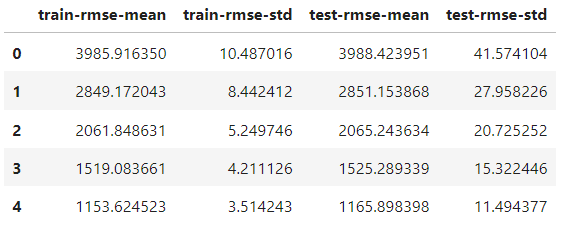

```python
best_rmse = results['test-rmse-mean'].min()

best_rmse
```

```
550.8959336674216
```

## XGBoost evaluation metrics

```python
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 1000

results = xgb.cv(
    params, dtrain_reg, 
    num_boost_round=n, 
    nfold=5,
    metrics=["rmse", "logloss", "mae"],
)
```

```
>>> results.columns
```

```
Index(['train-rmse-mean', 'train-rmse-std', 'train-logloss-mean',
       'train-logloss-std', 'train-mae-mean', 'train-mae-std',
       'test-rmse-mean', 'test-rmse-std', 'test-logloss-mean',
       'test-logloss-std', 'test-mae-mean', 'test-mae-std'],
      dtype='object')
```

```python
best_logloss = results['test-logloss-mean'].min()
best_rmse = results['test-rmse-mean'].min()
best_mae = results['test-mae-mean'].min()

print(f"""
Best logloss: {best_logloss:.3f}
Best RMSE:    {best_rmse:.3f}
Best MAE:     {best_mae:.3f}
""")
```

```
Best logloss: -179400.169
Best RMSE:    550.896
Best MAE:     281.304
```

## XGBoost hyperparameters
- Give brief and straightforward intro to Optuna for HP tuning
- Show how to create an objective and a study to tune XGB hyperparameters
- Show how to tune XGB models with Optuna

Learning hyperparameters:
- number of boosting rounds (n_estimators)
- `objective`
- `tree_method`
- `eta`, `learning_rate`
- `max_depth`
- `subsample`
- `colsample_bytree`

Regularization parameters:
- `lambda`
- `alpha`

## XGBoost hyperparameter tuning

```python
import optuna


def objective(trial):

    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'eta': trial.suggest_uniform('eta', 0.001, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }
    
    # Specify the number of boosting rounds
    num_boost_round = 10000
    
    # Train the model using XGBoost's native API
    results = xgb.cv(
            params, 
            dtrain_reg,
            nfold=5, 
            num_boost_round=num_boost_round, 
            early_stopping_rounds=50,
        )
    
    # Return the metric to be optimized
    return results['test-rmse-mean'].min()
```

```python
# Run the optimization using Optuna
study = optuna.create_study(direction="minimize", study_name="regression")
study.optimize(objective, n_trials=10, show_progress_bar=True)
```

![](images/optuna_study.gif)

```python
# Show the best hyperparameters found
print('Best hyperparameters:', study.best_params)
```

```
Best hyperparameters: {'eta': 0.10477711297512081, 'max_depth': 6, 'subsample': 0.7328380083690756, 'colsample_bytree': 0.6475964362401979, 'lambda': 0.001234187578969112, 'alpha': 0.0016253562744209514}
```

## Classification in XGBoost
- Discuss a few classification metrics and objective functions XGB offers
- Build the DMatrix for a classification task
- Train and evaluate an XGBoost model

```python
from sklearn.preprocessing import OrdinalEncoder

X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
    X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)
```

```python
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
```

```python
params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 5}
n = 1000

results = xgb.cv(
    params, dtrain_clf, 
    num_boost_round=n, 
    nfold=5,
    metrics=["mlogloss", "auc", "merror"],
)
```

```
results.keys()
```

```
Index(['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean',
       'train-auc-std', 'train-merror-mean', 'train-merror-std',
       'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean',
       'test-auc-std', 'test-merror-mean', 'test-merror-std'],
      dtype='object')
```

```
>>> results['test-auc-mean'].max()
```

```
0.9402233623451636
```

## XGBoost native API vs. Scikit-learn API
- List the differences between two APIs of XGB
- Show how to switch models between two APIs even after training

## Feature importances
- Extracting and plotting feature importances
- Why feature importances is important

## Why XGBoost performs so well?
- Discuss the internals of XGB without getting into math and the details too much

## Wrap